<font size='6px'>
📝 <b>GAN Tutorial: Part 2 - GAN Tutorial Module (GTM)</b></font>

<font color='orange'> **written by Rai--** </font>

### Prerequisites (only for Colab users, otherwise please skip)

In [1]:
!pip install tensorflow==2.16.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
   

In [2]:
!git clone https://github.com/Seismic-DL-Research/seis-deep-learning --branch super_dev
%cd seis-deep-learning

Cloning into 'seis-deep-learning'...
remote: Enumerating objects: 1522, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 1522 (delta 165), reused 171 (delta 92), pack-reused 1276
Receiving objects: 100% (1522/1522), 5.70 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (965/965), done.
/content/seis-deep-learning


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf

# 1. Retrieving Sample Data

We will fetch a dataset to train our GAN model later. This dataset has been prerpocessed by the author. To be able to keep up with this tutorial, please download the dataset from the following link: https://drive.google.com/drive/folders/1vqsSlJn5XhsIATnH17iUxMUcu3m_6Flg?usp=sharing. Afterwards, please make a folder named ```sample_dataset``` in the working directory of this notebook. Paste all of the downloaded data into the ```sample_dataset``` folder. Make sure that inside the folder, there is only ```.tfr``` data downlaoded from the link!

**Do not run this following code. Only works for the author!**

In [5]:
import os
import shutil

In [6]:
shutil.copytree('../drive/MyDrive/thesis/processed_tfrs', 'sample_dataset')

'sample_dataset'

# 2. Reading Dataset

I assume that you are already familiar with the TFRecord. If you want to learn more about TFRecord, please visit: https://colab.research.google.com/drive/1xH0pdQVC1Dv_wR1Co-VwTjdFqk6dB5d8

In [7]:
# our parse config
parse_config = {'data': tf.io.FixedLenFeature([], tf.string)}

In [8]:
# define mapping function
def map_reading(data):
  parsed_example = tf.io.parse_example(data, parse_config)
  mapped_data = tf.io.parse_tensor(parsed_example['data'], tf.float32)
  return mapped_data

In [10]:
# training dataset
p_train = tf.data.TFRecordDataset('sample_dataset/train-p.tfr').map(map_reading)
n_train = tf.data.TFRecordDataset('sample_dataset/train-n.tfr').map(map_reading)

# validation dataset
p_val = tf.data.TFRecordDataset('sample_dataset/valid-p.tfr').map(map_reading)
n_val = tf.data.TFRecordDataset('sample_dataset/valid-n.tfr').map(map_reading)

#  3. The ```gtm``` Module

GTM stands for GAN Tutorial Module, which is a module made by the author that offers easability for constructing GAN and training GAN. The author has reconstructed all of the methods that we have gone through into three main modules which are ```gtm.models.GAN``` , ```gtm.models.discriminative``` and ```gtm.models.generative```. These moduls are designed to be as easy as possible to specifically design and train GAN for seismic P-phase detection. As we already have covered all the theoretical and basic practices of GAN, now we will delve into how to leverage this module. We will no longer delve into math anymore from this point on. Let's import the GTM module.

In [80]:
import gan_tutorial_modules as gtm

## Configuring GAN

In [85]:
def gtm_update(gtm):
  pending_for_deletion = []
  for i in sys.modules:
    if i.split('.')[0] == 'gan_tutorial_modules':
      pending_for_deletion.append(i)

  for i in pending_for_deletion:
    del sys.modules[i]

  import gan_tutorial_modules as gtm
  return gtm

In [86]:
import sys
gtm = gtm_update(gtm)

To initiate our training, we configure our GAN model using ```gtm.models.GAN()```. Take a look at the parameters that is required to initiate the ```gan``` class object. I assume that these parameters are easy to understand if you have understood quite well the tutorial we have gone through.

In [13]:
gan = gtm.models.GAN(epoch=5,
                    batch_size=512,
                    window_length=350,
                    generative_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    discriminative_optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
                    generative_total_iterations=2,
                    discriminative_total_iterations=3,
                    generative_latent_sample_size=50,
                    generative_latent_sample_mean=0,
                    generative_latent_sample_stdev=0.6,
                    p_wave_dataset=p_train, # data assigned must contain any batch size!
                    n_wave_dataset=n_train, # data assigned must contain any batch size!
                    p_wave_dataset_val=p_val, # data assigned must contain any batch size!
                    n_wave_dataset_val=n_val # data assigned must contain any batch size!
                    )


We initiate the ```generative``` object class using ```gtm.models.Generative()```. The initiation process of this class requires ```gan``` object. This principle also applies for the ```discriminative``` object.

In [14]:
generative = gtm.models.Generative(gan)
discriminative = gtm.models.Discriminative(gan)

## Working with Models: Get Models and Update Models

By default, both of these objects already have sample models. These sample models are identical to the tutorial.

In [15]:
discriminative.model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 350)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vec_add_channel_1 (VecAddChannel)    │ (None, 350, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 346, 3)              │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 339, 4)              │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 330, 3)              │             123 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 165, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 495)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         126,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,482 (665.95 KB)

 Trainable params: 170,482 (665.95 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
generative.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vec_add_channel (VecAddChannel)      │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 56, 2)               │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 67, 4)               │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 82, 8)               │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_3 (Conv1DTranspose) │ (None, 93, 6)               │             582 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 558)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 400)                 │         223,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 350)                 │         140,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,168 (1.39 MB)

 Trainable params: 365,168 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

You can update the model by calling method ```update_model```. Let's update the generator model with the following model.

In [17]:
# designing a new generator model
new_model_input = tf.keras.layers.Input(shape=(25,))
cont = tf.keras.layers.Dense(300)(new_model_input)
new_model_output = tf.keras.layers.Dense(355)(cont)

# creating a new generator model
new_model = tf.keras.Model(inputs=[new_model_input], outputs=[new_model_output])

# updating generator model in the generative object
generative.update_model(new_model)

Invalid input shape! Expected 50 but obtained 25
Invalid output shape! Expected 350 but obtained 355


As you can see, we have errors. These errors are raised because our model does not align with the configuration that we have set in advance in the ```GAN``` object initiation's parameters. Let's fix it and see the updated model.

In [18]:
# designing a new generator model
new_model_input = tf.keras.layers.Input(shape=(50,))
cont = tf.keras.layers.Dense(300)(new_model_input)
new_model_output = tf.keras.layers.Dense(350)(cont)

# creating a new generator model
new_model = tf.keras.Model(inputs=[new_model_input], outputs=[new_model_output])

# updating generator model in the generative object
generative.update_model(new_model)

generative.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 300)                 │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 350)                 │         105,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,650 (471.29 KB)

 Trainable params: 120,650 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

Now the model is updated. You can also access the model via ```GAN``` object. The model in ```GAN``` object is automatically updated.

In [19]:
gan.generative_module.model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 300)                 │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 350)                 │         105,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,650 (471.29 KB)

 Trainable params: 120,650 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

## Training with Sample Dataset

Let's revert back our generative model into the default one.

In [20]:
generative = gtm.models.Generative(gan)

At this point, we want to train our models, especially the discriminative model to recognize the P wave signal from the real seismic data. We continue using the sample models to get through this tutorial. Let's obtain the performance of our model at its initial state. Sure thing we have poor confusion matrix scores here.

In [21]:
gan.evaluate()

{'d_loss': 699.1911948067801,
 'true_positive': 0,
 'false_positive': 0,
 'true_negative': 14197,
 'false_negative': 14197}

Let's train them! All we need to do is passing ```gan.train()``` to our code. Remember that we have configured anything in the first place.

In [22]:
gan.train()

Epoch 1 out of 5
LOGS: L_D_val: 33.3356 | TP: 13959 | TN: 14098 | FP: 99 | FN: 238 

Found 194 batches per epoch
Epoch 2 out of 5


|██████████████████████████████| [00:46<00:00] L_G: 1261.2589 | L_D: 72.6214


LOGS: L_D_val: 72.8392 | TP: 12921 | TN: 14183 | FP: 14 | FN: 1276 

Epoch 3 out of 5


|██████████████████████████████| [00:46<00:00] L_G: 1801.7778 | L_D: 32.4380


LOGS: L_D_val: 23.9544 | TP: 14018 | TN: 14135 | FP: 62 | FN: 179 

Epoch 4 out of 5


|██████████████████████████████| [00:46<00:00] L_G: 2383.5386 | L_D: 14.0453


LOGS: L_D_val: 16.9280 | TP: 14002 | TN: 14155 | FP: 42 | FN: 195 

Epoch 5 out of 5


|██████████████████████████████| [00:45<00:00] L_G: 5840.4482 | L_D: 40.0805


LOGS: L_D_val: 34.0723 | TP: 13719 | TN: 14160 | FP: 37 | FN: 478 



WARNING! Sometimes TensorFlow's warning messages appear, disturbing the tqdm progress bar. Upon each epoch, we obtain the confusion matrix values and the discriminator loss in the validation dataset.

In [23]:
gan.evaluate()

{'d_loss': 34.07229719843183,
 'true_positive': 13719,
 'false_positive': 37,
 'true_negative': 14160,
 'false_negative': 478}

As you can see, there is an improvement. Now feel free to explore this module on your own! You can design your own model, hypertune it according to your necessity. Don't forget to save the model after you finished training.

**Furthur update is on the way! Visit https://github.com/Seismic-DL-Research/seis-deep-learning/tree/super_dev to see updates.**

# Additional: 3 Chanelled-GAN

In [83]:
# importing modules
import gan_tutorial_modules as gtm
import tensorflow as tf
import pydot

from tensorflow.keras.layers import Dense, Conv1DTranspose, Input, Flatten, Conv1D, \
AveragePooling1D, Reshape

In [40]:
LATENT_SIZE = 50
WINDOW_LENGTH = 350

In [119]:
n_like = tf.random.normal((1000, 350, 3))
n_like_val = tf.random.normal((1000, 350, 3))

p_like_n = tf.random.normal((1000, 100, 3))
p_like_p = tf.random.normal((1000, 250, 3), stddev=2)
p_like = tf.concat([p_like_n, p_like_p], axis=1)

p_like_n = tf.random.normal((1000, 100, 3))
p_like_p = tf.random.normal((1000, 250, 3), stddev=2)
p_like_val = tf.concat([p_like_n, p_like_p], axis=1)

p_like = tf.data.Dataset.from_tensor_slices(p_like).batch(32)
p_like_val = tf.data.Dataset.from_tensor_slices(p_like_val).batch(32)
n_like = tf.data.Dataset.from_tensor_slices(n_like).batch(32)
n_like_val = tf.data.Dataset.from_tensor_slices(n_like_val).batch(32)

In [120]:
gan = gtm.models.GAN(epoch=5,
                    batch_size=512,
                    window_length=WINDOW_LENGTH,
                    generative_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    discriminative_optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
                    generative_total_iterations=2,
                    discriminative_total_iterations=3,
                    generative_latent_sample_size=LATENT_SIZE,
                    generative_latent_sample_mean=0,
                    generative_latent_sample_stdev=0.6,
                    channel='zne',
                    p_wave_dataset=p_like, # data assigned must contain any batch size!
                    n_wave_dataset=n_like, # data assigned must contain any batch size!
                    p_wave_dataset_val=p_like_val, # data assigned must contain any batch size!
                    n_wave_dataset_val=n_like_val # data assigned must contain any batch size!
                    )

generative = gtm.models.Generative(gan)
discriminative = gtm.models.Discriminative(gan)

In [122]:
# customized layer: split channel layer
@tf.keras.utils.register_keras_serializable(
    package="gan-tutorial",
    name="SplitChannel",
)
class SplitChannel(tf.keras.Layer):
  def __init__(sf):
    # The method called when the class's object is initiated.

    # We call the parent's constructor
    super().__init__()

  def build(sf, input_shape):
    # This method usually contains trainable weights. We won't add
    # any for this layer.
    pass

  def call(sf, input):
    # We returned its expanded dims form.
    return tf.split(input, num_or_size_splits=3, axis=-1)

In [129]:
input_layer = Input(shape=(WINDOW_LENGTH,3))
split_channel = SplitChannel()(input_layer)

def discriminator_submodel():
  input_layer = Input(shape=(350,1))
  cont = Flatten()(input_layer)
  cont = Dense(250)(cont)
  cont = Dense(100)(cont)
  cont = Dense(50)(cont)
  return tf.keras.Model(inputs=input_layer, outputs=cont)


discriminator_submodel0 = discriminator_submodel()(split_channel[0])
discriminator_submodel1 = discriminator_submodel()(split_channel[1])
discriminator_submodel2 = discriminator_submodel()(split_channel[2])

concat = tf.keras.layers.concatenate([discriminator_submodel0,
                                      discriminator_submodel1,
                                      discriminator_submodel2],
                                      axis=-1)

cont = Dense(20)(concat)
cont = Dense(1)(cont)

updated_discriminative_model = tf.keras.Model(inputs=[input_layer], outputs=[cont])

In [127]:
input_layer = Input(shape=(LATENT_SIZE,3))
split_channel = SplitChannel()(input_layer)
def generator_submodel():
  input_layer = Input(shape=(50,1))
  cont = Conv1DTranspose(filters=2, kernel_size=7, 
                         activation='leaky_relu')(input_layer)
  cont = Conv1DTranspose(filters=6, kernel_size=8, 
                         activation='leaky_relu')(cont)
  cont = Conv1DTranspose(filters=8, kernel_size=3, 
                         activation='leaky_relu')(cont)
  cont = Conv1DTranspose(filters=8, kernel_size=2, 
                         activation='leaky_relu')(cont)
  cont = AveragePooling1D(pool_size=2)(cont)
  cont = Flatten()(cont)
  cont = Dense(300, activation='leaky_relu')(cont)
  cont = Dense(350, activation='leaky_relu')(cont)
  cont = Reshape(target_shape=(350,1))(cont)
  return tf.keras.Model(inputs=input_layer, outputs=cont)

generator_submodel0 = generator_submodel()(split_channel[0])
generator_submodel1 = generator_submodel()(split_channel[1])
generator_submodel2 = generator_submodel()(split_channel[2])

concat = tf.keras.layers.concatenate([generator_submodel0,
                                      generator_submodel1,
                                      generator_submodel2], axis=-1)

updated_generative_model = tf.keras.Model(inputs=[input_layer], outputs=[concat])

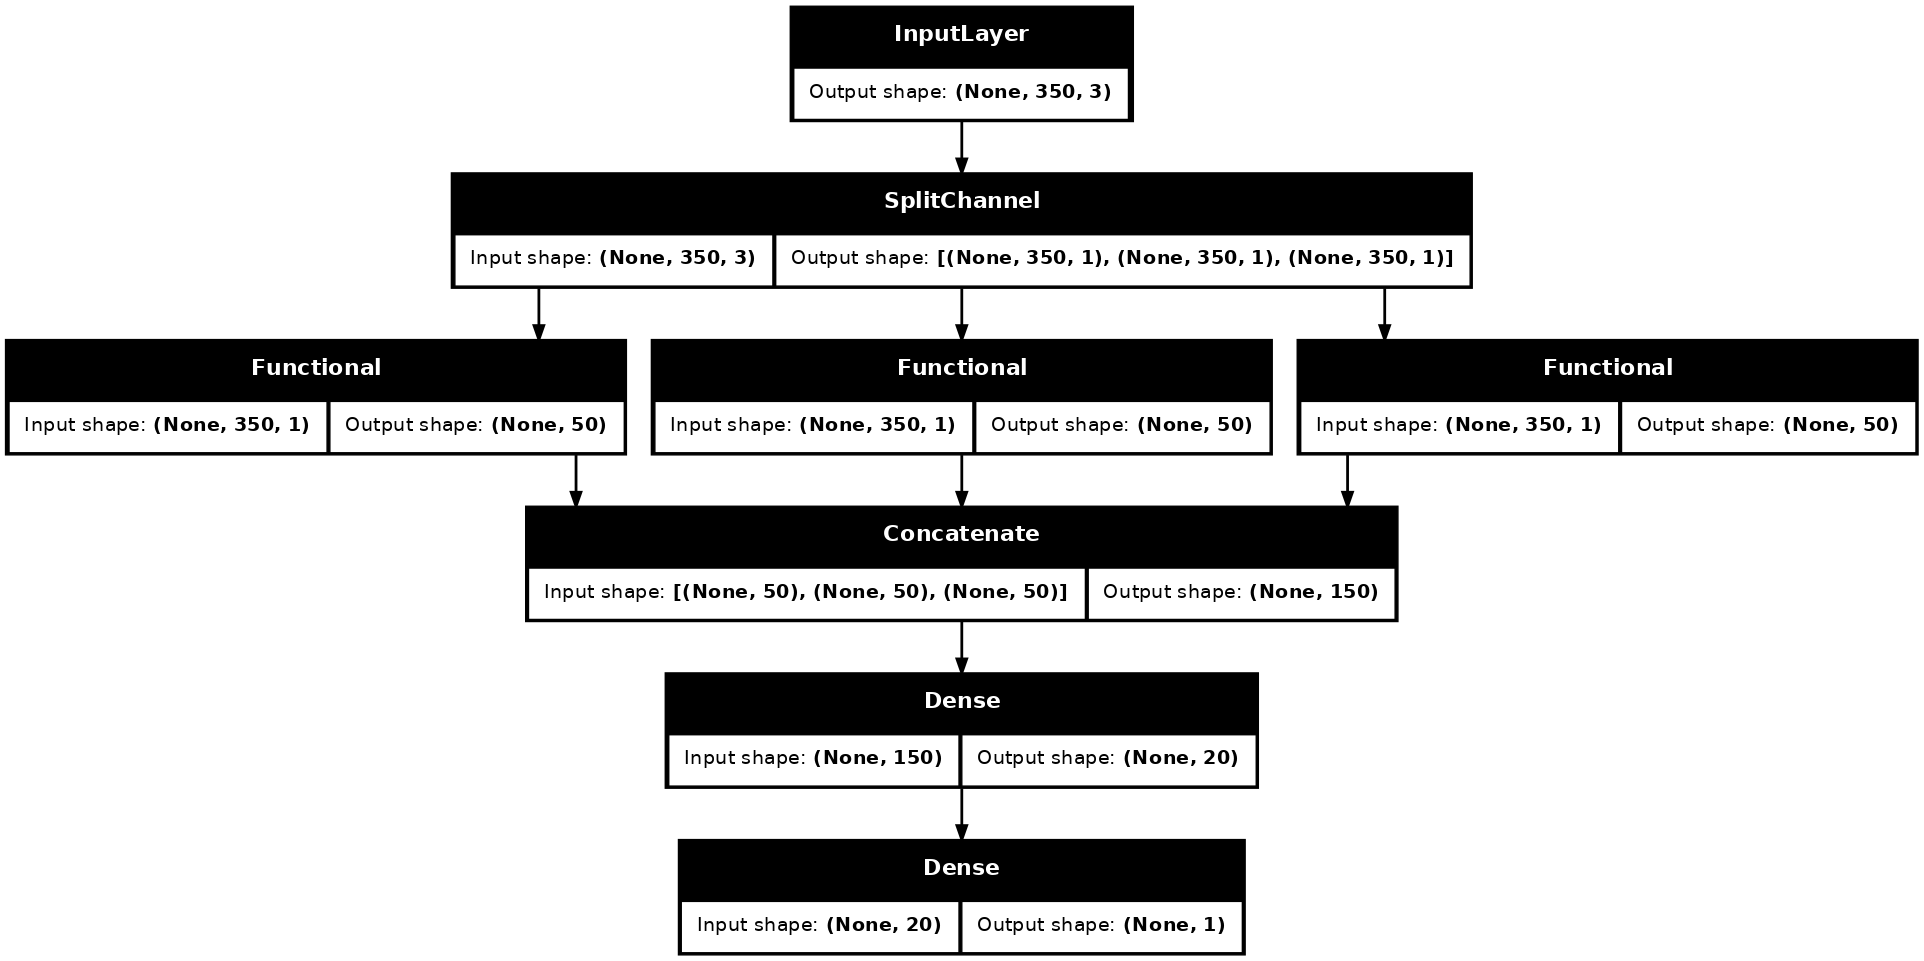

In [130]:
# must install pydot, graphviz, and pydot_ng to work
# pip install pydot
# pip install pydot_ng==2.0.0
# sudo apt install graphviz (for ubuntu and debian) 
tf.keras.utils.plot_model(updated_discriminative_model, dpi=100, show_shapes=True)

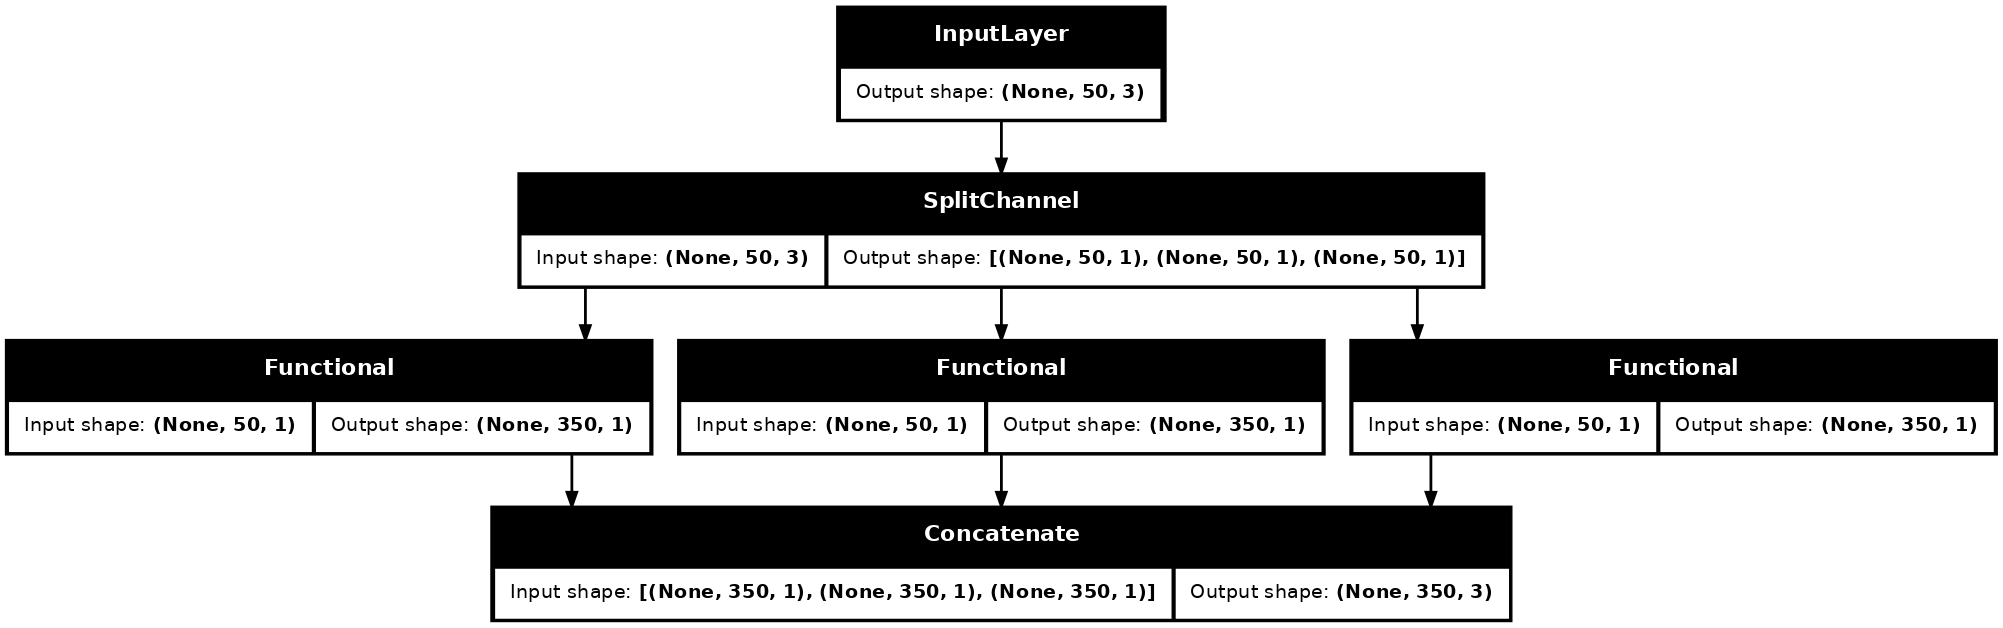

In [128]:
# must install pydot, graphviz, and pydot_ng to work
# pip install pydot
# pip install pydot_ng==2.0.0
# sudo apt install graphviz (for ubuntu and debian) 
tf.keras.utils.plot_model(updated_generative_model, dpi=100, show_shapes=True)

In [131]:
discriminative.update_model(update_discriminative_model)
generative.update_model(updated_generative_model)

In [ ]:
gan.train()